This is the notebook that demonstrates how to classify labels images using KNN algorithm

The k-Nearest Neighbor classifier is by far the most simple machine learning and image classi- fication algorithm. It doesn’t actually “learn” anything. Instead, this algorithm directly relies on the distance between feature vectors (which in our case, are the raw RGB pixel intensities of the images).

k-NN algorithm classifies unknown data points by finding the most common class among the k closest examples. Each data point in the k closest data points casts a vote, and the category with the highest number of votes wins. Or, in plain English: “Tell me who your neighbors are, and I’ll tell you who you are”

K- Nearest Neighbors is a

Supervised machine learning algorithm

Non parametric as it does not make an assumption about the underlying data distribution pattern

It doesnt have the training step,here K stands for Number of neighbours.It uses distance metric *like *L1 ,L2 distance to predict the label of new point into N-dimensional space

Pros:

Learns complex models easily.
Robust to noisy data, 3 No training phase involved as it direclty relies on labels of K nearest neighbours 4 Effective if training set is large 5 Classifying a new testing point requires a comparison to every single data point in our training data, which scales O(N), making working with larger datasets computationally prohibitive.
Cons

Difficult to choose value of K in this approach
Difficut to estimate which distance could give best result. 3 Not effective if data has high dimensional since large storage is required,low computational efficiency ,data sparsity ,false intuition,close nearest neighbours becomes less relevant
Works well if data is low dimensional

In [26]:
# mounting the drive dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import torch
import cv2
import os
from IPython.display import Image

In [28]:
!ls /content/drive/MyDrive/Computer_Vision/examination/crops

banana	      frame322.jpg  frame390.jpg  frame458.jpg	frame555.jpg
banana.jpg    frame323.jpg  frame391.jpg  frame459.jpg	frame556.jpg
banana.png    frame324.jpg  frame392.jpg  frame460.jpg	frame557.jpg
cassava       frame325.jpg  frame393.jpg  frame461.jpg	frame558.jpg
cassava.jpg   frame326.jpg  frame394.jpg  frame462.jpg	frame559.jpg
cassava.png   frame327.jpg  frame395.jpg  frame463.jpg	frame560.jpg
frame260.jpg  frame328.jpg  frame396.jpg  frame464.jpg	frame561.jpg
frame261.jpg  frame329.jpg  frame397.jpg  frame465.jpg	frame562.jpg
frame262.jpg  frame330.jpg  frame398.jpg  frame466.jpg	frame563.jpg
frame263.jpg  frame331.jpg  frame399.jpg  frame467.jpg	frame564.jpg
frame264.jpg  frame332.jpg  frame400.jpg  frame468.jpg	frame565.jpg
frame265.jpg  frame333.jpg  frame401.jpg  frame469.jpg	frame566.jpg
frame266.jpg  frame334.jpg  frame402.jpg  frame470.jpg	frame567.jpg
frame267.jpg  frame335.jpg  frame403.jpg  frame471.jpg	frame568.jpg
frame268.jpg  frame336.jpg  frame404.jpg  frame47

Here is the class SimpleDatasetLoader which loads the dataset fom the drive and it gives data and label,which are tuple of numpy array of data and labels

Implement SimpleDatasetLoader

In [29]:
#Class to load the dataset images from drivce
import os
import cv2
import numpy as np


class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

Machine learning algorithm such as k-NN require all images in a dataset to have a fixed feature vector size.

In the case of images, this requirement implies that our images must be preprocessed and scaled to have identical widths and heights.

There are a number of ways to accomplish this resizing and scaling, ranging from more advanced methods that respect the aspect ratio of the original image to the scaled image to simple methods that ignore the aspect ratio and simply squash the width and height to the required dimensions

class SimplePreprocessor builds an image preprocessor that resizes the image, ignoring the aspect ratio.

Implementing SimplePreprocessor

In [30]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

Cassava and banana Inspection

In [66]:
# Using cv2.imread() method
cassava = '/content/drive/MyDrive/Computer_Vision/examination/crops/cassava.png'
img_cassava = cv2.imread(cassava)
banana = '/content/drive/MyDrive/Computer_Vision/examination/crops/banana.png'
img_banana = cv2.imread(banana)

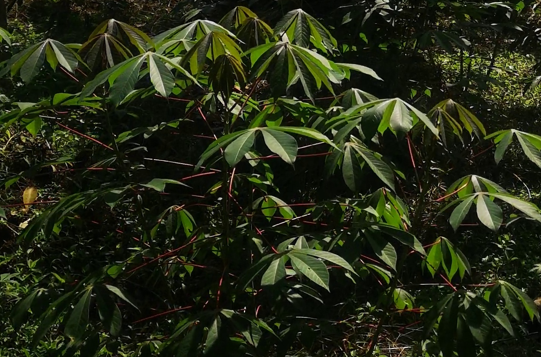

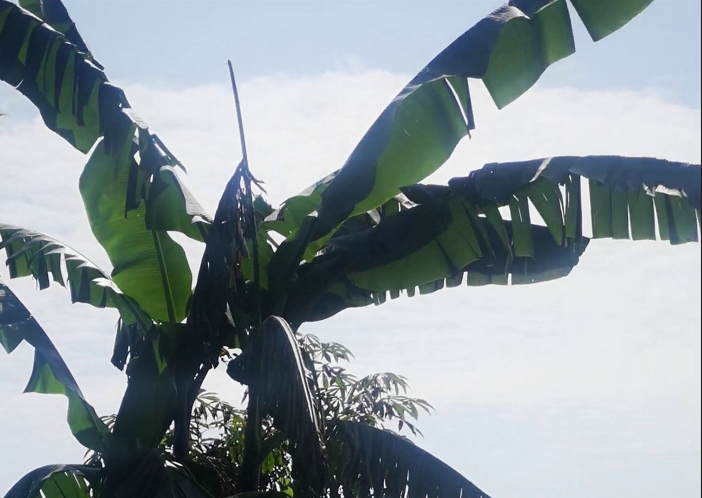

In [69]:
import cv2
# cassava
cv2_imshow(img_cassava)
# banana
cv2_imshow(img_banana)

cv2.waitKey(0)
cv2.destroyAllWindows()

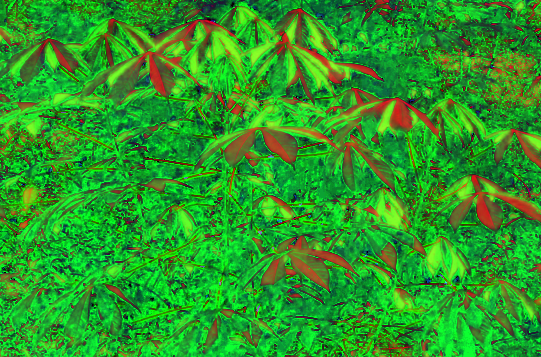

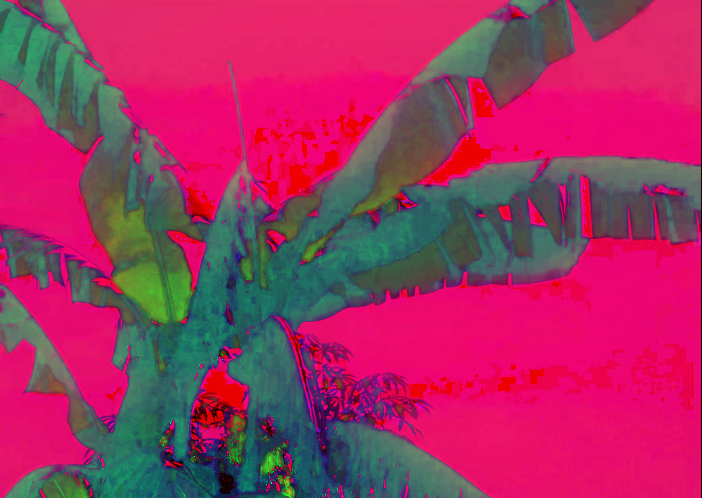

In [68]:
# converting BGR to HSV
image_rgb = cv2.cvtColor(img_cassava, cv2.COLOR_BGR2HSV)
image_rgbb = cv2.cvtColor(img_banana, cv2.COLOR_BGR2HSV)

cv2_imshow(image_rgb)
cv2_imshow(image_rgbb)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [53]:
# import cv2
# import numpy as np
# from PIL import Image

# # img = cv2.imread("path/to/img.png")

# # You may need to convert the color.
# img = cv2.cvtColor(img_cassava, cv2.COLOR_BGR2RGB)
# im_pil = Image.fromarray(img)

# im_pil


Color Histograms

cassava histogram

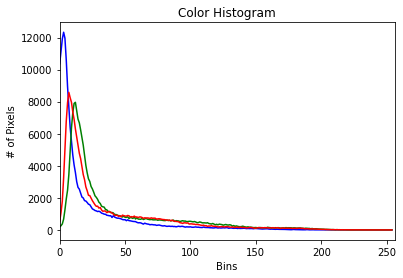

In [70]:
from matplotlib import pyplot as plt
import cv2

channels = cv2.split(img_cassava)
colors = ("b", "g", "r")

plt.figure()
plt.title("Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []

# Loop over the image channels (B, G, R)
for (channel, color) in zip(channels, colors):

    # Calculate histogram
    hist = cv2.calcHist([channel], [0], None, [255], [1, 256])
    features.extend(hist)

    # Plot histogram
    plt.plot(hist, color = color)
    plt.xlim([0, 256])

plt.show()

banana histogram

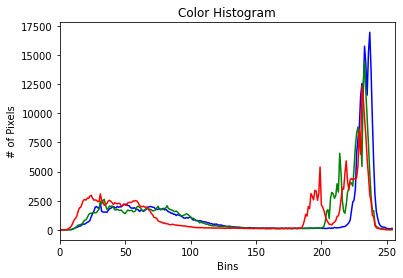

In [71]:
from matplotlib import pyplot as plt
import cv2

channels = cv2.split(img_banana)
colors = ("b", "g", "r")

plt.figure()
plt.title("Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []

# Loop over the image channels (B, G, R)
for (channel, color) in zip(channels, colors):

    # Calculate histogram
    hist = cv2.calcHist([channel], [0], None, [255], [1, 256])
    features.extend(hist)

    # Plot histogram
    plt.plot(hist, color = color)
    plt.xlim([0, 256])

plt.show()

SIFT feature extraction algorithm 

SIFT cassava

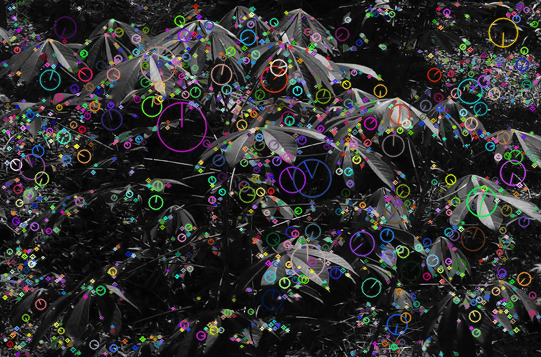

In [72]:
# !pip install opencv-contrib-python

# Important NOTE:  Use opencv <= 3.4.2.16 as
# SIFT is no longer available in
# opencv > 3.4.2.16
import cv2
 
# Loading the image
img = img_cassava
 
 # Converting image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
# Applying SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
cv2.imwrite('image-with-keypoints.jpg', img)
cv2_imshow(img)

SIFT banana

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


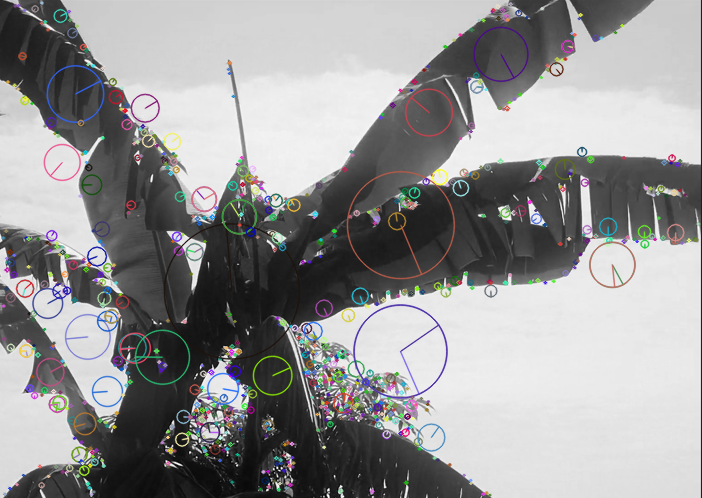

In [73]:
!pip install opencv-contrib-python

# Important NOTE:  Use opencv <= 3.4.2.16 as
# SIFT is no longer available in
# opencv > 3.4.2.16
import cv2
 
# Loading the image
img = img_banana
 
 # Converting image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
# Applying SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
cv2.imwrite('image-with-keypoints.jpg', img)
cv2_imshow(img)

Implementing k-NN

• Step #1 –** Gather Our Dataset**: The datasets consists of 1,000 images with 1,000 images containing banana and cassava plants plus the other plants in the garden.Each image is represented in the RGB76 color space. We will preprocess each image by resizing it to 32 × 32 pixels. Taking into account the three RGB channels, the resized image dimensions imply that each image in the dataset is represented by 32 × 32 × 3 = 3, 072 integers.

• Step #2 – Split the Dataset: We will split the data, One split for training, and the other for testing. 

• Step #3 – Train the Classifier: Our k-NN classifier will be trained on the raw pixel intensi- ties of the images in the training set.

• Step #4 – Evaluate: Once our k-NN classifier is trained, we can evaluate performance on the test set.

In [74]:
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader




# Get list of image paths
image_paths = list(paths.list_images("/content/drive/MyDrive/Computer_Vision/examination/crops"))

In [75]:
# image_paths
# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (1000, 32, 32, 3) to (1000, 32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: Classification starting....')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1)
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

[INFO]: Images loading....
[INFO]: Processed 500/750
[INFO]: Features Matrix: 2250000.0MB
[INFO]: Classification starting....
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        52
     cassava       0.98      1.00      0.99        46
       crops       1.00      0.99      0.99        90

    accuracy                           0.99       188
   macro avg       0.99      1.00      0.99       188
weighted avg       0.99      0.99      0.99       188



How to find Best K?

In [76]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np 

model = KNeighborsClassifier(n_neighbors=2,n_jobs=1)
model.fit(train_x, train_y)

accuracy = accuracy_score(model.predict(test_x), test_y)
print(accuracy)
n_neighbors = np.array([7,8,9,10,12,15,20])
param_grid = dict(n_neighbors=n_neighbors)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train_x, train_y)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.9946808510638298
0.9946902654867257
7


In [77]:
import matplotlib.pyplot as plt
#print(grid.cv_results_)
print(grid.param_grid)
print(grid.best_score_)
print(grid.scorer_)

{'n_neighbors': array([ 7,  8,  9, 10, 12, 15, 20])}
0.9946902654867257
<function _passthrough_scorer at 0x7f3894919050>


Classifying a new testing point requires a comparison to every single data point in our training data, which scales O(N), making working with larger datasets computationally prohibitive.CasaCccn# Using cv2.imread() method
cassava = '/content/drive/MyDrive/Computer_Vision/examination/crop200/cassava.png'
img_cassava = cv2.imread(cassava)inspe

How to make KNN Faster?

In [78]:
# pip install scikit-learn

In [85]:
 #algorithm='ball_tree'
 #its fs
  
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4,cluster_std = 1.5, random_state = 4)

# Get list of image paths
image_paths = list(paths.list_images("/content/drive/MyDrive/Computer_Vision/examination/crops"))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (3000, 32, 32, 3) to (3000, 32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.3, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: Classification starting....')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1,algorithm='kd_tree')
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

[INFO]: Images loading....
[INFO]: Processed 500/750
[INFO]: Features Matrix: 2250000.0MB
[INFO]: Classification starting....
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        63
     cassava       0.97      1.00      0.98        57
       crops       1.00      0.98      0.99       105

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225

